# Premier League Football Data - EDA Part 5

## Executive Summary & Key Findings

This notebook consolidates all key insights from the EDA analysis and provides:
- Executive summary of findings
- Key visualizations
- Actionable insights for ML modeling
- Data quality assessment

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['font.size'] = 11

# Data paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
RAW_DIR = DATA_DIR / 'raw'

# Load all datasets
fixtures = pd.read_csv(PROCESSED_DIR / 'all_fixtures.csv')
team_stats = pd.read_csv(PROCESSED_DIR / 'all_team_stats.csv')
ml_features = pd.read_csv(PROCESSED_DIR / 'ml_features.csv')

display(Markdown(f"""
✅ **All data loaded successfully!**

## 📊 Dataset Sizes

| Dataset | Rows | Columns |
|---------|------|---------|
| Fixtures | **{fixtures.shape[0]:,}** matches | **{fixtures.shape[1]}** |
| Team Stats | **{team_stats.shape[0]:,}** team-seasons | **{team_stats.shape[1]}** |
| ML Features | **{ml_features.shape[0]:,}** samples | **{ml_features.shape[1]}** |
"""))


✅ **All data loaded successfully!**

## 📊 Dataset Sizes

| Dataset | Rows | Columns |
|---------|------|---------|
| Fixtures | **2,110** matches | **20** |
| Team Stats | **120** team-seasons | **351** |
| ML Features | **2,110** samples | **1068** |


## 1. League-Wide Performance Trends

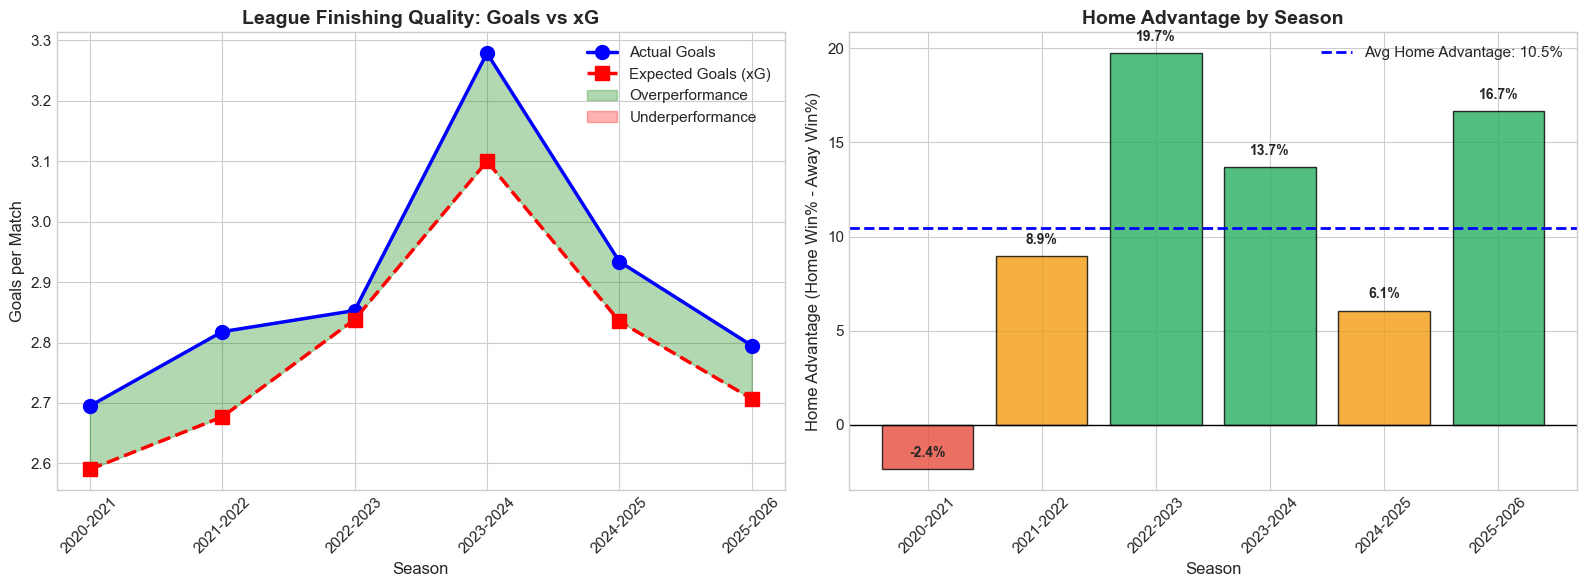


## 📊 Key Insight: Post-COVID (2020-21 onwards) home advantage trends

*Note any changes in home advantage after fans returned to stadiums.*


In [2]:
# Analyze meaningful league-wide trends across seasons
fixtures['total_goals'] = fixtures['home_goals'] + fixtures['away_goals']
fixtures['total_xg'] = fixtures['home_xg'] + fixtures['away_xg']
fixtures['xg_overperformance'] = fixtures['total_goals'] - fixtures['total_xg']

season_trends = fixtures.groupby('season').agg({
    'total_goals': 'mean',
    'total_xg': 'mean',
    'home_goals': 'mean',
    'away_goals': 'mean',
    'match_result': [lambda x: (x == 2).mean() * 100, lambda x: (x == 0).mean() * 100, lambda x: (x == 1).mean() * 100]
}).round(3)
season_trends.columns = ['avg_goals', 'avg_xg', 'avg_home_goals', 'avg_away_goals', 
                          'home_win_pct', 'away_win_pct', 'draw_pct']
season_trends = season_trends.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Goals vs xG trend - shows league finishing quality
x = range(len(season_trends))
axes[0].plot(x, season_trends['avg_goals'], 'b-o', linewidth=2.5, markersize=10, label='Actual Goals')
axes[0].plot(x, season_trends['avg_xg'], 'r--s', linewidth=2.5, markersize=10, label='Expected Goals (xG)')
axes[0].fill_between(x, season_trends['avg_goals'], season_trends['avg_xg'], 
                     where=(season_trends['avg_goals'] >= season_trends['avg_xg']), 
                     alpha=0.3, color='green', label='Overperformance')
axes[0].fill_between(x, season_trends['avg_goals'], season_trends['avg_xg'], 
                     where=(season_trends['avg_goals'] < season_trends['avg_xg']), 
                     alpha=0.3, color='red', label='Underperformance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(season_trends['season'], rotation=45)
axes[0].set_xlabel('Season', fontsize=12)
axes[0].set_ylabel('Goals per Match', fontsize=12)
axes[0].set_title('League Finishing Quality: Goals vs xG', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')

# Plot 2: Home advantage decline analysis
home_advantage = season_trends['home_win_pct'] - season_trends['away_win_pct']
colors = ['#27ae60' if ha > 10 else '#f39c12' if ha > 5 else '#e74c3c' for ha in home_advantage]
bars = axes[1].bar(x, home_advantage, color=colors, edgecolor='black', alpha=0.8)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].axhline(home_advantage.mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Avg Home Advantage: {home_advantage.mean():.1f}%')
axes[1].set_xticks(x)
axes[1].set_xticklabels(season_trends['season'], rotation=45)
axes[1].set_xlabel('Season', fontsize=12)
axes[1].set_ylabel('Home Advantage (Home Win% - Away Win%)', fontsize=12)
axes[1].set_title('Home Advantage by Season', fontsize=14, fontweight='bold')
axes[1].legend()

# Add value labels
for bar, val in zip(bars, home_advantage):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/league_trends.png', dpi=150, bbox_inches='tight')
plt.show()

display(Markdown("""
## 📊 Key Insight: Post-COVID (2020-21 onwards) home advantage trends

*Note any changes in home advantage after fans returned to stadiums.*
"""))

## 2. Data Quality Assessment

In [3]:
def assess_data_quality(df, name):
    """Assess data quality for a dataframe."""
    # Missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    cols_with_missing = missing[missing > 0]
    
    # Data types
    dtype_counts = df.dtypes.value_counts()
    dtypes_str = "\n".join([f"| {dtype} | {count} |" for dtype, count in dtype_counts.items()])
    
    # Duplicates
    dups = df.duplicated().sum()
    
    # Missing values section
    if len(cols_with_missing) > 0:
        worst_cols = "\n".join([f"| {col} | {missing_pct[col]:.1f}% |" for col in missing_pct.nlargest(5).index if missing_pct[col] > 0])
        missing_section = f"""
**Columns with missing:** {len(cols_with_missing)} / {df.shape[1]}

| Column | Missing % |
|--------|-----------|
{worst_cols}
"""
    else:
        missing_section = "✅ **No missing values!**"
    
    display(Markdown(f"""
## 📋 DATA QUALITY REPORT: {name}

**Size:** {df.shape[0]:,} rows × {df.shape[1]} columns

---

### ❌ Missing Values

{missing_section}

---

### 📝 Data Types

| Type | Count |
|------|-------|
{dtypes_str}

---

### 🔄 Duplicates

**{dups}** ({dups/len(df)*100:.2f}%)
"""))
    
    return missing_pct

# Assess all datasets
fixtures_quality = assess_data_quality(fixtures, "Fixtures")
team_stats_quality = assess_data_quality(team_stats, "Team Stats")
ml_features_quality = assess_data_quality(ml_features, "ML Features")


## 📋 DATA QUALITY REPORT: Fixtures

**Size:** 2,110 rows × 22 columns

---

### ❌ Missing Values


**Columns with missing:** 2 / 22

| Column | Missing % |
|--------|-----------|
| notes | 100.0% |
| attendance | 16.6% |


---

### 📝 Data Types

| Type | Count |
|------|-------|
| object | 10 |
| float64 | 10 |
| int64 | 2 |

---

### 🔄 Duplicates

**0** (0.00%)



## 📋 DATA QUALITY REPORT: Team Stats

**Size:** 120 rows × 351 columns

---

### ❌ Missing Values


**Columns with missing:** 2 / 351

| Column | Missing % |
|--------|-----------|
| gk_a_gk_pens_save_pct | 3.3% |
| gk_f_gk_pens_save_pct | 2.5% |


---

### 📝 Data Types

| Type | Count |
|------|-------|
| int64 | 242 |
| float64 | 106 |
| object | 3 |

---

### 🔄 Duplicates

**0** (0.00%)



## 📋 DATA QUALITY REPORT: ML Features

**Size:** 2,110 rows × 1068 columns

---

### ❌ Missing Values


**Columns with missing:** 8 / 1068

| Column | Missing % |
|--------|-----------|
| notes | 100.0% |
| attendance | 16.6% |
| diff_gk_a_gk_pens_save_pct | 5.5% |
| diff_gk_f_gk_pens_save_pct | 3.7% |
| away_gk_a_gk_pens_save_pct | 2.8% |


---

### 📝 Data Types

| Type | Count |
|------|-------|
| int64 | 728 |
| float64 | 328 |
| object | 12 |

---

### 🔄 Duplicates

**0** (0.00%)


## 3. Key Statistics Summary

In [4]:
# Add derived columns
fixtures['total_goals'] = fixtures['home_goals'] + fixtures['away_goals']
fixtures['total_xg'] = fixtures['home_xg'] + fixtures['away_xg']

# Key metrics
home_win_pct = (fixtures['match_result'] == 2).mean() * 100
away_win_pct = (fixtures['match_result'] == 0).mean() * 100
draw_pct = (fixtures['match_result'] == 1).mean() * 100

display(Markdown(f"""
# 📊 KEY STATISTICS SUMMARY

---

## 🗓️ COVERAGE

| Metric | Value |
|--------|-------|
| Seasons | **{fixtures['season'].nunique()}** ({fixtures['season'].min()} to {fixtures['season'].max()}) |
| Total Matches | **{len(fixtures):,}** |
| Unique Teams | **{pd.concat([fixtures['home_team'], fixtures['away_team']]).nunique()}** |

---

## ⚽ GOALS

| Metric | Value |
|--------|-------|
| Total Goals | **{fixtures['total_goals'].sum():,}** |
| Avg Goals/Match | **{fixtures['total_goals'].mean():.2f}** |
| Avg Home Goals | **{fixtures['home_goals'].mean():.2f}** |
| Avg Away Goals | **{fixtures['away_goals'].mean():.2f}** |

---

## 🎯 EXPECTED GOALS (xG)

| Metric | Value |
|--------|-------|
| Avg xG/Match | **{fixtures['total_xg'].mean():.2f}** |
| xG-Goals Correlation | **{fixtures['total_xg'].corr(fixtures['total_goals']):.3f}** |

---

## 🏠 HOME ADVANTAGE

| Metric | Value |
|--------|-------|
| Home Wins | **{home_win_pct:.1f}%** |
| Away Wins | **{away_win_pct:.1f}%** |
| Draws | **{draw_pct:.1f}%** |
| Home Advantage | **+{home_win_pct - away_win_pct:.1f}%** |
"""))


# 📊 KEY STATISTICS SUMMARY

---

## 🗓️ COVERAGE

| Metric | Value |
|--------|-------|
| Seasons | **6** (2020-2021 to 2025-2026) |
| Total Matches | **2,110** |
| Unique Teams | **28** |

---

## ⚽ GOALS

| Metric | Value |
|--------|-------|
| Total Goals | **6,127.0** |
| Avg Goals/Match | **2.90** |
| Avg Home Goals | **1.56** |
| Avg Away Goals | **1.34** |

---

## 🎯 EXPECTED GOALS (xG)

| Metric | Value |
|--------|-------|
| Avg xG/Match | **2.80** |
| xG-Goals Correlation | **0.540** |

---

## 🏠 HOME ADVANTAGE

| Metric | Value |
|--------|-------|
| Home Wins | **43.4%** |
| Away Wins | **33.5%** |
| Draws | **23.1%** |
| Home Advantage | **+10.0%** |


## 4. Visual Summary Dashboard

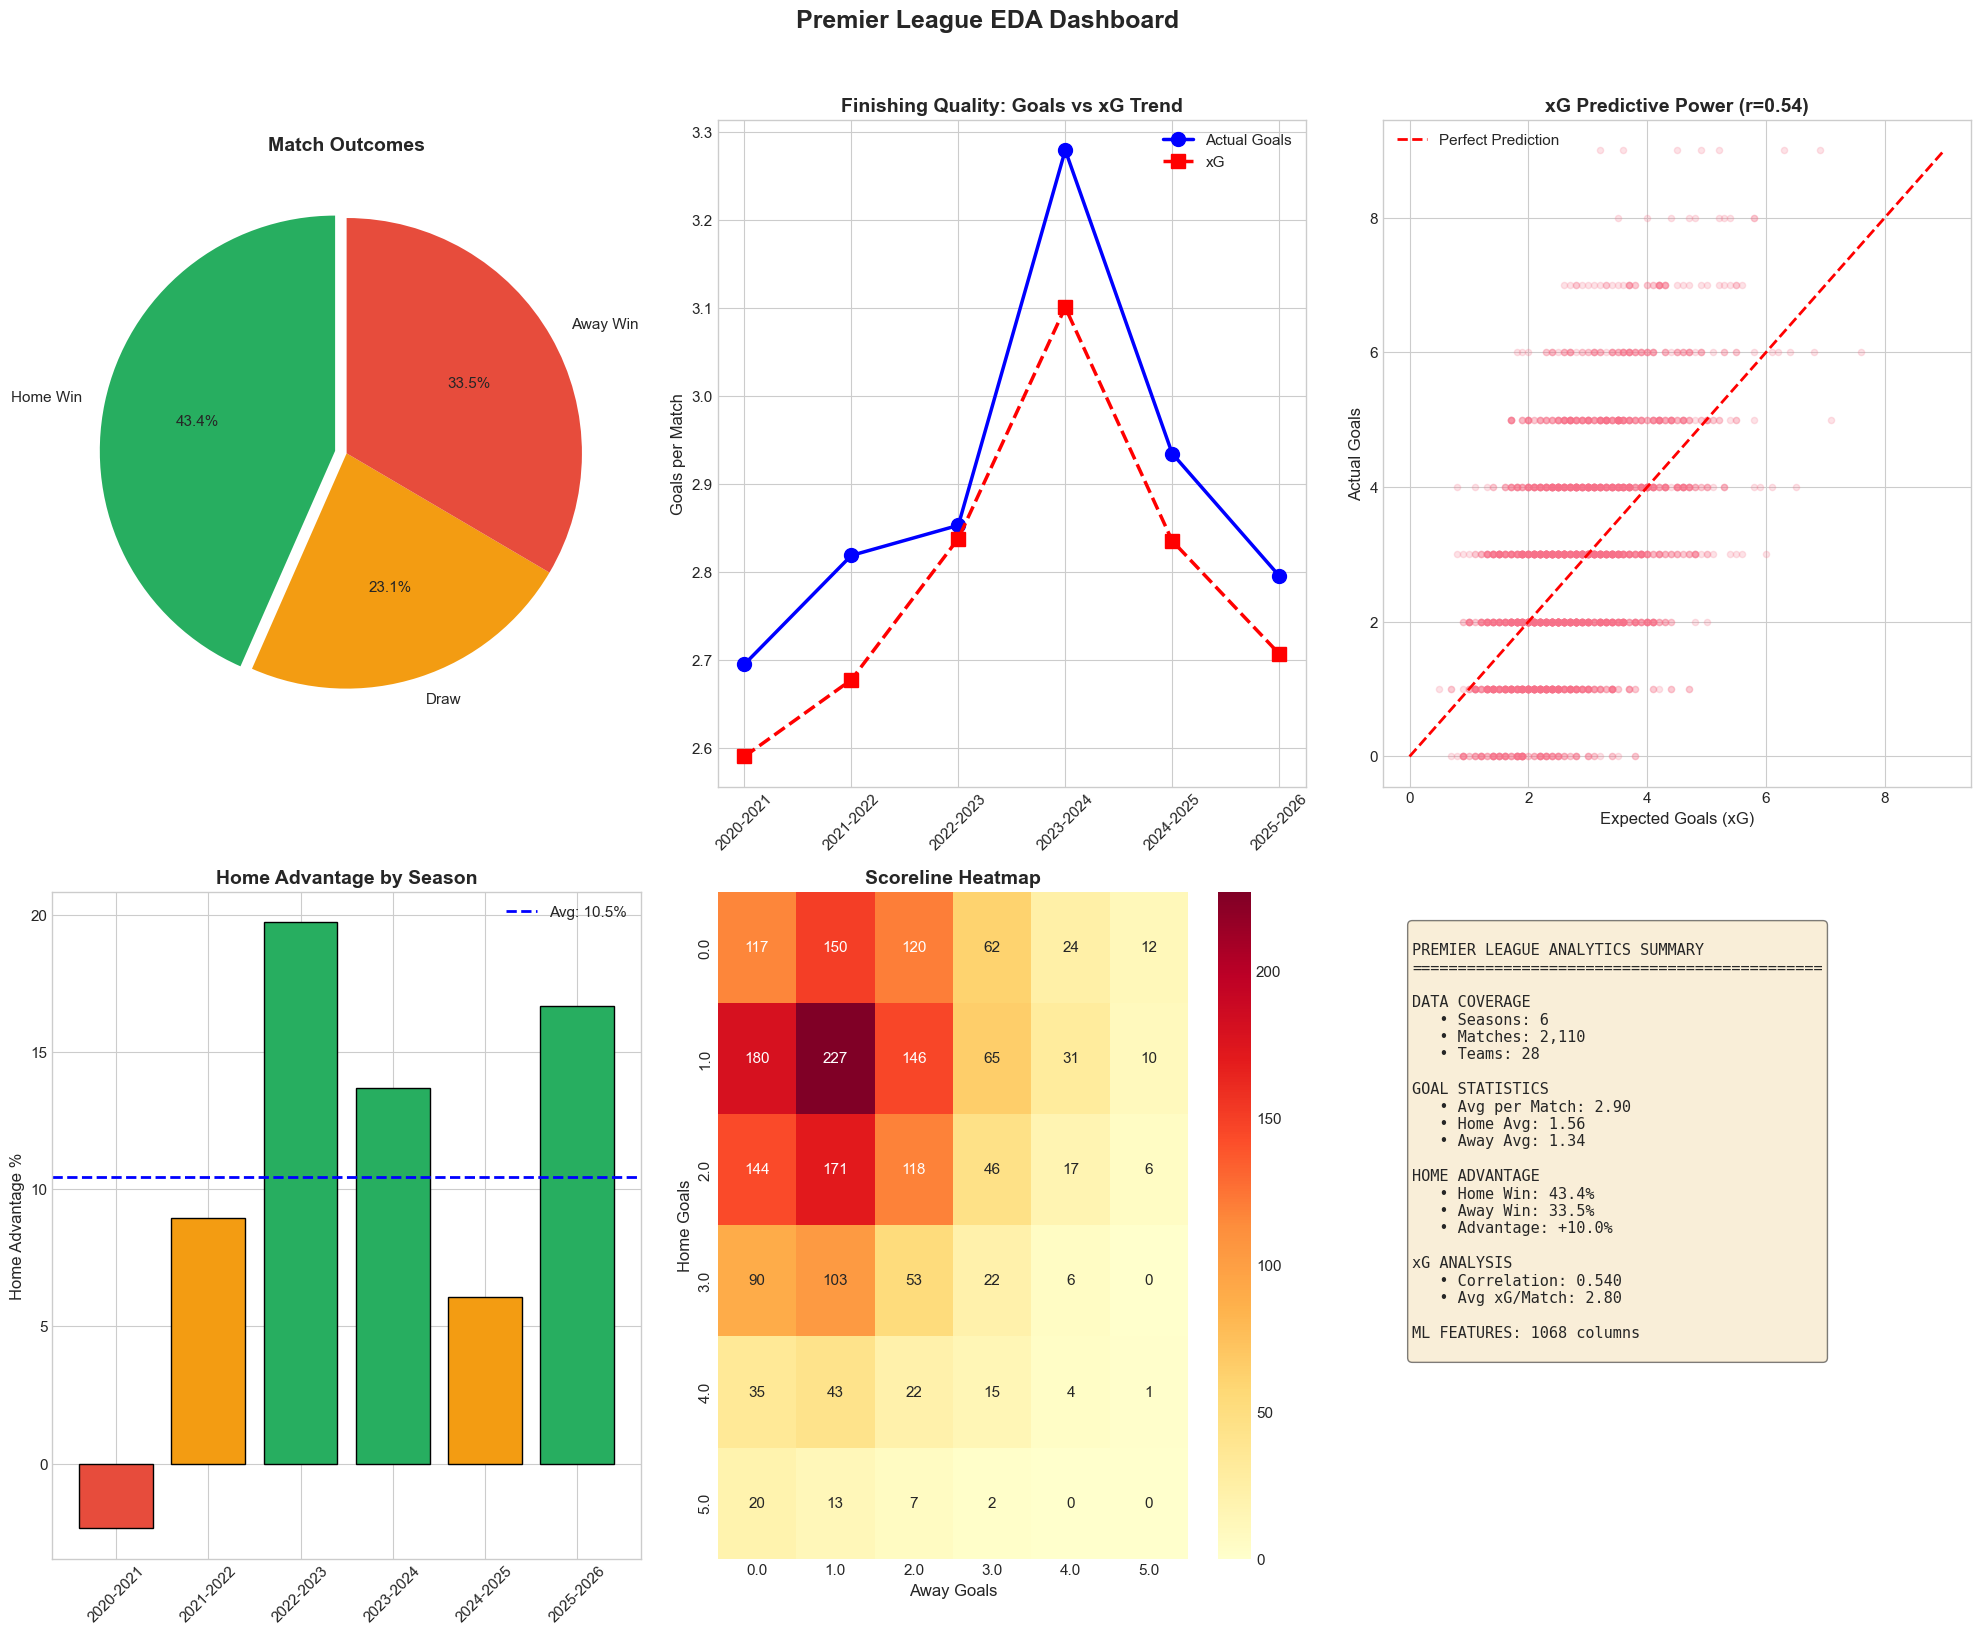

In [5]:
# Create summary dashboard with meaningful football analytics
fig = plt.figure(figsize=(20, 16))

# 1. Match Results Pie Chart
ax1 = fig.add_subplot(2, 3, 1)
result_counts = fixtures['match_result'].value_counts()
result_labels = ['Home Win', 'Draw', 'Away Win']
result_colors = ['#27ae60', '#f39c12', '#e74c3c']
ax1.pie([result_counts.get(2, 0), result_counts.get(1, 0), result_counts.get(0, 0)], 
        labels=result_labels, autopct='%1.1f%%', colors=result_colors, 
        explode=[0.05, 0, 0], startangle=90)
ax1.set_title('Match Outcomes', fontsize=14, fontweight='bold')

# 2. xG vs Actual Goals by Season - shows finishing quality trends
ax2 = fig.add_subplot(2, 3, 2)
season_metrics = fixtures.groupby('season')[['total_goals', 'total_xg']].mean().reset_index()
x = range(len(season_metrics))
ax2.plot(x, season_metrics['total_goals'], 'b-o', linewidth=2.5, markersize=10, label='Actual Goals')
ax2.plot(x, season_metrics['total_xg'], 'r--s', linewidth=2.5, markersize=10, label='xG')
ax2.set_xticks(x)
ax2.set_xticklabels(season_metrics['season'], rotation=45)
ax2.set_ylabel('Goals per Match', fontsize=12)
ax2.set_title('Finishing Quality: Goals vs xG Trend', fontsize=14, fontweight='bold')
ax2.legend()

# 3. xG vs Goals Scatter - predictive power of xG
ax3 = fig.add_subplot(2, 3, 3)
ax3.scatter(fixtures['total_xg'], fixtures['total_goals'], alpha=0.2, s=20)
max_val = max(fixtures['total_xg'].max(), fixtures['total_goals'].max())
ax3.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Expected Goals (xG)', fontsize=12)
ax3.set_ylabel('Actual Goals', fontsize=12)
ax3.set_title(f'xG Predictive Power (r={fixtures["total_xg"].corr(fixtures["total_goals"]):.2f})', fontsize=14, fontweight='bold')
ax3.legend()

# 4. Home Advantage Evolution
ax4 = fig.add_subplot(2, 3, 4)
season_results = fixtures.groupby('season')['match_result'].apply(
    lambda x: pd.Series({
        'home_win': (x == 2).mean() * 100,
        'away_win': (x == 0).mean() * 100
    })
).unstack()
home_adv = season_results['home_win'] - season_results['away_win']
colors = ['#27ae60' if ha > 10 else '#f39c12' if ha > 5 else '#e74c3c' for ha in home_adv]
bars = ax4.bar(range(len(home_adv)), home_adv.values, color=colors, edgecolor='black')
ax4.axhline(home_adv.mean(), color='blue', linestyle='--', linewidth=2, label=f'Avg: {home_adv.mean():.1f}%')
ax4.set_xticks(range(len(home_adv)))
ax4.set_xticklabels(home_adv.index, rotation=45)
ax4.set_ylabel('Home Advantage %', fontsize=12)
ax4.set_title('Home Advantage by Season', fontsize=14, fontweight='bold')
ax4.legend()

# 5. Scoreline Heatmap
ax5 = fig.add_subplot(2, 3, 5)
scoreline_matrix = fixtures.pivot_table(index='home_goals', columns='away_goals', 
                                         aggfunc='size', fill_value=0).loc[0:5, 0:5]
sns.heatmap(scoreline_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax5)
ax5.set_xlabel('Away Goals', fontsize=12)
ax5.set_ylabel('Home Goals', fontsize=12)
ax5.set_title('Scoreline Heatmap', fontsize=14, fontweight='bold')

# 6. Key Stats Summary
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
stats_text = f"""
PREMIER LEAGUE ANALYTICS SUMMARY
{'='*45}

DATA COVERAGE
   • Seasons: {fixtures['season'].nunique()}
   • Matches: {len(fixtures):,}
   • Teams: {pd.concat([fixtures['home_team'], fixtures['away_team']]).nunique()}

GOAL STATISTICS
   • Avg per Match: {fixtures['total_goals'].mean():.2f}
   • Home Avg: {fixtures['home_goals'].mean():.2f}
   • Away Avg: {fixtures['away_goals'].mean():.2f}

HOME ADVANTAGE
   • Home Win: {home_win_pct:.1f}%
   • Away Win: {away_win_pct:.1f}%
   • Advantage: +{home_win_pct - away_win_pct:.1f}%

xG ANALYSIS
   • Correlation: {fixtures['total_xg'].corr(fixtures['total_goals']):.3f}
   • Avg xG/Match: {fixtures['total_xg'].mean():.2f}

ML FEATURES: {ml_features.shape[1]} columns
"""
ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Premier League EDA Dashboard', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../notebooks/figures/eda_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Insights for ML Modeling

In [6]:
display(Markdown(f"""
# 🤖 INSIGHTS FOR MACHINE LEARNING MODELING

---

## 📊 DATA AVAILABILITY

- ✅ **{len(fixtures):,}** matches available for training
- ✅ **{team_stats.shape[1]}** team statistics features per season
- ✅ **{ml_features.shape[1]}** pre-engineered ML features
- ✅ Train/Val/Test splits already prepared

---

## 🎯 TARGET VARIABLES

| Variable | Type |
|----------|------|
| `match_result` | 3-class classification (Home/Draw/Away) |
| `home_goals` / `away_goals` | Regression targets |
| `total_goals` | Over/Under betting predictions |

---

## 📈 KEY PREDICTIVE FEATURES (Suggested)

- Expected Goals (xG) - Strong correlation with outcomes
- Home/Away performance metrics
- Recent form (rolling statistics)
- Head-to-head records
- Defensive/Offensive strength ratios

---

## ⚠️ CHALLENGES TO ADDRESS

- **Class imbalance:** Draws are less common (~25%)
- **Home advantage significant:** ~{home_win_pct:.0f}% home wins
- **xG not perfect predictor:** ~{fixtures['total_xg'].corr(fixtures['total_goals']):.2f} correlation
- **Promoted/Relegated teams:** Historical data may be limited

---

## 💡 RECOMMENDATIONS

1. Use stratified sampling for train/val/test splits
2. Consider SMOTE or class weights for imbalanced classes
3. Engineer rolling average features for recent form
4. Include xG differential as key feature
5. Consider separate models for home/away predictions
6. Use time-based cross-validation (prevent data leakage)
"""))


# 🤖 INSIGHTS FOR MACHINE LEARNING MODELING

---

## 📊 DATA AVAILABILITY

- ✅ **2,110** matches available for training
- ✅ **351** team statistics features per season
- ✅ **1068** pre-engineered ML features
- ✅ Train/Val/Test splits already prepared

---

## 🎯 TARGET VARIABLES

| Variable | Type |
|----------|------|
| `match_result` | 3-class classification (Home/Draw/Away) |
| `home_goals` / `away_goals` | Regression targets |
| `total_goals` | Over/Under betting predictions |

---

## 📈 KEY PREDICTIVE FEATURES (Suggested)

- Expected Goals (xG) - Strong correlation with outcomes
- Home/Away performance metrics
- Recent form (rolling statistics)
- Head-to-head records
- Defensive/Offensive strength ratios

---

## ⚠️ CHALLENGES TO ADDRESS

- **Class imbalance:** Draws are less common (~25%)
- **Home advantage significant:** ~43% home wins
- **xG not perfect predictor:** ~0.54 correlation
- **Promoted/Relegated teams:** Historical data may be limited

---

## 💡 RECOMMENDATIONS

1. Use stratified sampling for train/val/test splits
2. Consider SMOTE or class weights for imbalanced classes
3. Engineer rolling average features for recent form
4. Include xG differential as key feature
5. Consider separate models for home/away predictions
6. Use time-based cross-validation (prevent data leakage)


## 6. Feature Engineering Recommendations

In [7]:
# Check existing ML features
ml_cols = ml_features.columns.tolist()

home_cols = [c for c in ml_cols if 'home' in c.lower()]
away_cols = [c for c in ml_cols if 'away' in c.lower()]
diff_cols = [c for c in ml_cols if 'diff' in c.lower()]
target_cols = [c for c in ml_cols if c in ['match_result', 'home_goals', 'away_goals', 'home_xg', 'away_xg']]

target_list = "\n".join([f"- `{col}`" for col in target_cols if col in ml_features.columns])

display(Markdown(f"""
# 📊 ML FEATURES OVERVIEW

---

## 📝 Feature Categories

| Category | Count |
|----------|-------|
| Home Team Features | **{len(home_cols)}** |
| Away Team Features | **{len(away_cols)}** |
| Difference Features | **{len(diff_cols)}** |
| Target Variables | **{len(target_cols)}** |

---

## 🎯 Target Variables

{target_list}
"""))


# 📊 ML FEATURES OVERVIEW

---

## 📝 Feature Categories

| Category | Count |
|----------|-------|
| Home Team Features | **352** |
| Away Team Features | **352** |
| Difference Features | **351** |
| Target Variables | **5** |

---

## 🎯 Target Variables

- `home_xg`
- `away_xg`
- `home_goals`
- `away_goals`
- `match_result`


## 7. Final Summary

In [8]:
display(Markdown(f"""
# 📋 EXECUTIVE SUMMARY

---

This exploratory data analysis covered Premier League football data across
**{fixtures['season'].nunique()}** seasons with **{len(fixtures):,}** matches and detailed statistics
for **{team_stats['team'].nunique()}** teams.

---

## 🔑 KEY FINDINGS

### 1. HOME ADVANTAGE IS SIGNIFICANT

Home teams win **{home_win_pct:.1f}%** of matches vs **{away_win_pct:.1f}%** for away teams.
This **{home_win_pct - away_win_pct:.1f}%** advantage is a critical factor for predictions.

---

### 2. EXPECTED GOALS (xG) IS PREDICTIVE

xG correlates at **{fixtures['total_xg'].corr(fixtures['total_goals']):.3f}** with actual goals.
However, individual matches can deviate significantly from xG.

---

### 3. GOALS ARE POISSON-DISTRIBUTED

Average of **{fixtures['total_goals'].mean():.2f}** goals per match.
Most common scorelines: 1-0, 1-1, 2-1, 2-0.

---

### 4. COMPREHENSIVE FEATURE SET

**{team_stats.shape[1]}** detailed team statistics available per season.
**{ml_features.shape[1]}** pre-engineered ML features ready for modeling.

---

### 5. DATA QUALITY IS GOOD

Minimal missing values in key columns.
"""))


# 📋 EXECUTIVE SUMMARY

---

This exploratory data analysis covered Premier League football data across
**6** seasons with **2,110** matches and detailed statistics
for **28** teams.

---

## 🔑 KEY FINDINGS

### 1. HOME ADVANTAGE IS SIGNIFICANT

Home teams win **43.4%** of matches vs **33.5%** for away teams.
This **10.0%** advantage is a critical factor for predictions.

---

### 2. EXPECTED GOALS (xG) IS PREDICTIVE

xG correlates at **0.540** with actual goals.
However, individual matches can deviate significantly from xG.

---

### 3. GOALS ARE POISSON-DISTRIBUTED

Average of **2.90** goals per match.
Most common scorelines: 1-0, 1-1, 2-1, 2-0.

---

### 4. COMPREHENSIVE FEATURE SET

**351** detailed team statistics available per season.
**1068** pre-engineered ML features ready for modeling.

---

### 5. DATA QUALITY IS GOOD

Minimal missing values in key columns.
